In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from Deep_Learning.Representation_Learning.Utils.functional import cosine_schedule

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

  0%|          | 0/48000 [00:00<?, ?it/s]

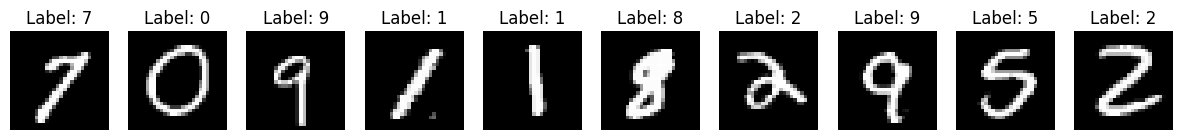

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [8]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])


train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [9]:
class EncBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bn=False, pool=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if pool else nn.Identity()
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.should_bn = bn
    
    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        if self.should_bn:
            x = self.bn(x)
        x = self.relu(x)
        return x
    
class DecBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, upsample=False):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size, stride, padding)
        self.upsample = nn.Upsample(scale_factor=2) if upsample else nn.Identity()
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        return x

H_DIM = 256
Z_DIM = 256
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            EncBlock(1, 32, 3, 1, 1, bn=True, pool=True),
            EncBlock(32, 64, 3, 1, 1, bn=True, pool=True),
            EncBlock(64, 128, 3, 1, 0, bn=True),
            EncBlock(128, 256, 3, 1, 0, bn=True),
            EncBlock(256, H_DIM, 3, 1, 0),
        )

        self.mu = nn.Linear(H_DIM, Z_DIM)
        self.logVar = nn.Linear(H_DIM, Z_DIM)
        self.z2h = nn.Linear(Z_DIM, H_DIM)

        self.decoder = nn.ModuleList([

            # nn.ConvTranspose2d(H_DIM, 256, 3, 1),
            # nn.ReLU(),

            # nn.ConvTranspose2d(256, 128, 3, 3),
            # nn.ReLU(),
            
            # nn.ConvTranspose2d(128, 64, 3, 3),
            # nn.ReLU(),
            
            # nn.ConvTranspose2d(64, 32, 2, 1),
            # nn.ReLU(),
            # nn.Conv2d(32, 1, 3, 1, 1),

            DecBlock(H_DIM, 256, 3, 1, 0),
            DecBlock(256, 128, 3, 1, 0),
            DecBlock(128, 64, 3, 1, 0),
            DecBlock(64, 32, 3, 1, 1, upsample=True),
            DecBlock(32, 32, 3, 1, 1, upsample=True),
            nn.Conv2d(32, 1, 3, 1, 1)
        ])

    def encode(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        h = self.encoder(x).flatten(1)
        mu, logVar = self.mu(h), self.logVar(h)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):

        h = self.z2h(z)
        h = h.view(-1, H_DIM, 1, 1)

        for i, layer in enumerate(self.decoder):
            h = layer(h)
            if i < len(self.decoder) - 1:
                h = F.relu(h)

        return h

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        x_hat = self.decode(z)
        return x_hat, mu, logVar

model = VAE().to(device)
x = torch.randn(10, 1, 28, 28).to(device)
model.encoder(x).shape
model(x)[0].shape

torch.Size([10, 1, 28, 28])

In [10]:
def loss_fn(recon_x, x, mu, log_var, beta):
    recon_loss = F.binary_cross_entropy_with_logits(recon_x, x, reduction="sum")
    mse = F.mse_loss(F.sigmoid(recon_x), x) * x.shape[0]
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (recon_loss + beta*kld), mse

def train(
        model,
        train_set,
        val_set,
        optimizer,
        lrs,
        wds,
        batch_size,
        beta,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    train_mses = []
    val_losses = []
    val_mses = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(len(lrs)):
        train_set.apply_transform()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        train_mse = 0 

        for param_group in optimizer.param_groups:
            param_group['lr'] = lrs[epoch].item()
        for param_group in optimizer.param_groups:
            if param_group['weight_decay'] != 0:
                param_group['weight_decay'] = wds[epoch].item()

        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{len(lrs)}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], train_mse=train_mses[-1], val_mse=val_mses[-1])

            with torch.cuda.amp.autocast():
                decoded, mu, log_var = model(x)
                loss, mse = loss_fn(decoded, x, mu, log_var, beta)
                # loss /= len(x)
            
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_mse += mse.item()
        
        train_losses.append(train_loss / len(train_set))
        train_mses.append(train_mse / len(train_set))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_mse = 0
            for x, _ in val_loader:
                decoded, mu, log_var = model(x)

                loss, mse = loss_fn(decoded, x, mu, log_var, beta)
                # loss /= len(x)
                val_loss += loss.item()
                val_mse += mse.item()

            val_losses.append(val_loss / len(val_set))
            val_mses.append(val_mse / len(val_set))
        
    return train_losses, val_losses, train_mses, val_mses

In [11]:
def get_optimiser(model, optimiser, lr, wd, exclude_bias=True, exclude_bn=True, momentum=0.9, betas=(0.9, 0.999)):
    non_decay_parameters = []
    decay_parameters = []   
    for n, p in model.named_parameters():
        if exclude_bias and 'bias' in n:
            non_decay_parameters.append(p)
        elif exclude_bn and 'bn' in n:
            non_decay_parameters.append(p)
        else:
            decay_parameters.append(p)
    non_decay_parameters = [{'params': non_decay_parameters, 'weight_decay': 0.0}]
    decay_parameters = [{'params': decay_parameters}]

    assert optimiser in ['AdamW', 'SGD'], 'optimiser must be one of ["AdamW", "SGD"]'
    if optimiser == 'AdamW':
        if momentum != 0.9:
            print('Warning: AdamW does not accept momentum parameter. Ignoring it. Please specify betas instead.')
        optimiser = torch.optim.AdamW(decay_parameters + non_decay_parameters, lr=lr, weight_decay=wd, betas=betas)
    elif optimiser == 'SGD':
        if betas != (0.9, 0.999):
            print('Warning: SGD does not accept betas parameter. Ignoring it. Please specify momentum instead.')
        optimiser = torch.optim.SGD(decay_parameters + non_decay_parameters, lr=lr, weight_decay=wd, momentum=momentum)
    
    return optimiser

In [12]:
EPOCHS = 250
BATCH_SIZE = 256
BETA = 0.75

base_lr = 3e-4
end_lr = 1e-6
warm_up_lrs = torch.linspace(0, base_lr, 10)
cosine_lrs = cosine_schedule(base_lr, end_lr, EPOCHS-10)
lrs = torch.cat([warm_up_lrs, cosine_lrs])

# WD schedule, cosine 
start_wd = 0.04
end_wd = 0.4
wds = cosine_schedule(start_wd, end_wd, EPOCHS)

model = VAE().to(device)
optimizer = get_optimiser(model, 'AdamW', lrs[0], wds[0], exclude_bias=True, exclude_bn=True)

train_losses, val_losses, train_mses, val_mses = train(model, train_set, val_set, optimizer, lrs, wds, BATCH_SIZE, BETA)

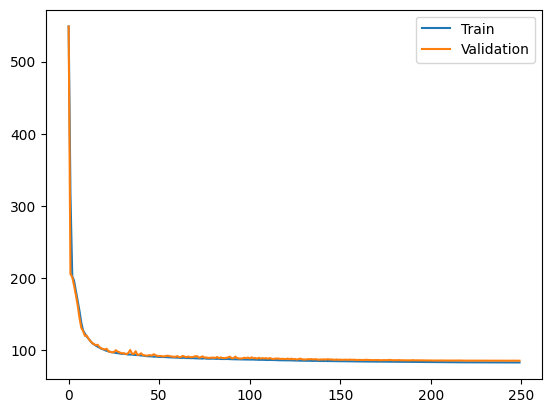

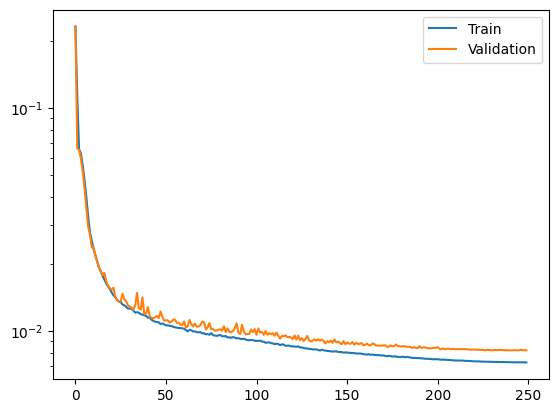

In [13]:
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()
# Plot mses
plt.plot(train_mses, label='Train')
plt.plot(val_mses, label='Validation')
plt.legend()
plt.yscale('log')
plt.show()

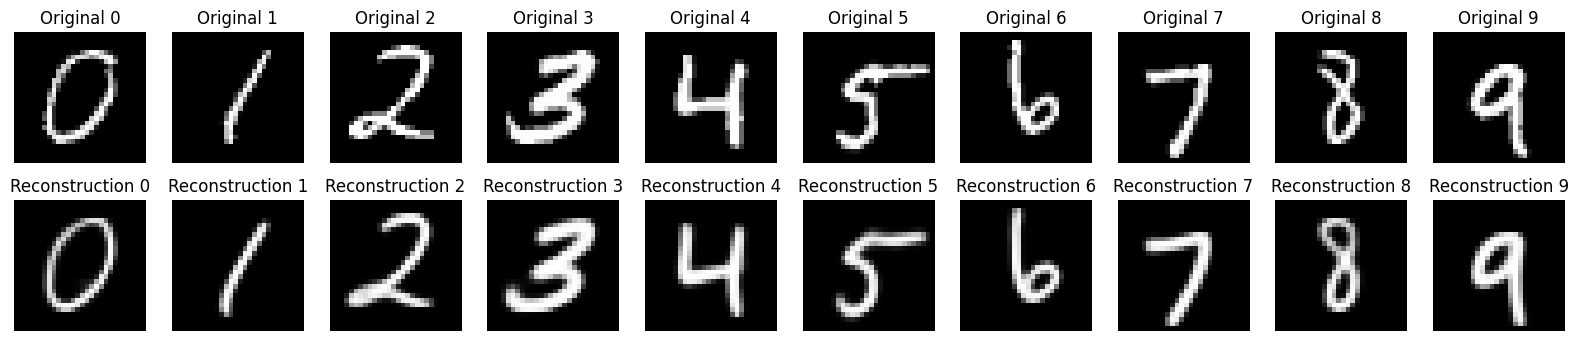

In [14]:
# Collect 1 image per class
images = {}
while len(images) < 10:
    idx = torch.randint(0, len(test_set), (1,)).item()
    x, y = test_set[idx]
    if y not in images:
        images[y.item()] = x

# Reconstruct images
reconstructions = {}
for y, x in images.items():
    x_hat, _, _ = model(x.unsqueeze(0))
    reconstructions[y] = F.sigmoid(x_hat.squeeze(0))

# Plot images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].cpu().detach().numpy().squeeze(), cmap='gray')
    axs[0, i].set_title(f'Original {i}')
    axs[1, i].set_title(f'Reconstruction {i}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

In [15]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(256, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)
    scaler = torch.cuda.amp.GradScaler()

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            with torch.cuda.amp.autocast():
                mu, _ = model.encode(x)
                pred = classifier(mu.detach())
                loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimiser)
            scaler.update()

            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            with torch.cuda.amp.autocast():
                mu, _ = model.encode(x)
                pred = classifier(mu.detach())
                loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [16]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, 100, BATCH_SIZE)

KeyboardInterrupt: 

Final validation accuracy: 90.31666666666666 %


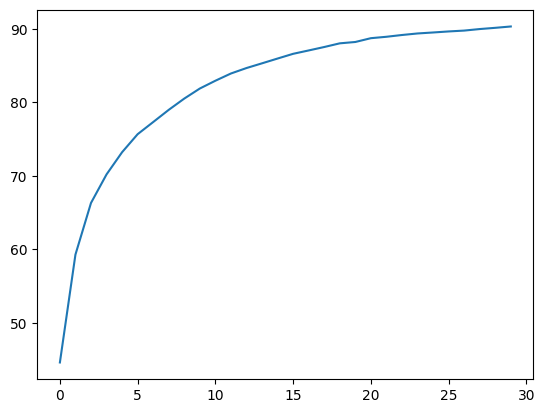

In [184]:
print('Final validation accuracy:', c_v_accs[-1], '%')
plt.plot(c_v_accs)